In [2]:

# import os
# os.chdir('/content/MultiTradingEnv/MultiTrading/RL-Final-Env')
# print(os.getcwd())
from Env import MultiTradingEnv,State,Action
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

In [3]:
stocks=['63MOONS.csv','NHPC.csv','BIOCON.csv','BHEL.csv']
stocks=['BSOFT.csv','BIRLACORPN.csv','BLUECOAST.csv','BLUEDART.csv']
stocks=['btc_30m.csv','ETH_1H.csv']

dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
path='/home/siddharth/Desktop/MultiTrading/'
timesteps=20000
for name in stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    dataframes.append(df)


In [8]:
import ta

def preprocess(data):
    long_sma_window = 50
    short_sma_window = 20
    data['feature_Long_SMA'] = data['Close'].rolling(window=long_sma_window, min_periods=1).mean()
    data['feature_Short_SMA'] = data['Close'].rolling(window=short_sma_window, min_periods=1).mean()
    data['feature_RSI'] = ta.momentum.rsi(close=data['Close'], window=14)
    data["feature_Close"] = data["Close"].pct_change()
    data["feature_Open"] = data["Open"]/data["Close"]
    data["feature_High"] = data["High"]/data["Close"]
    data["feature_Low"] = data["Low"]/data["Close"]
    data['feature_MACD'] = ta.trend.macd(data["Close"])
    data['feature_CCI'] = ta.trend.cci(data["High"], data["Low"], data["Close"], window=20)
    data['feature_BB_upper'], data['feature_BB_middle'], data['feature_BB_lower'] = ta.volatility.bollinger_hband(data["Close"]), ta.volatility.bollinger_mavg(data["Close"]), ta.volatility.bollinger_lband(data["Close"])
    data['feature_Slowk']= ta.momentum.stoch(data["High"], data["Low"], data["Close"])
    data['feature_ATR'] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)


In [9]:
norm_dataframes=[]
for i in range(len(dataframes)):
    df=dataframes[i]
    preprocess(df)
    dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_dataframes.append(df)
for i in norm_dataframes:
    print(i)

           Open     Close      High       Low    Volume  feature_Long_SMA  \
0      0.750999  0.744842  0.751882  0.750967  0.026574          0.747308   
1      0.745711  0.733217  0.750149  0.737866  0.044301          0.747663   
2      0.733231  0.739274  0.743340  0.737148  0.026906          0.748218   
3      0.739171  0.730564  0.740267  0.725197  0.038400          0.748423   
4      0.730582  0.727264  0.733823  0.730526  0.028001          0.748501   
...         ...       ...       ...       ...       ...               ...   
19944  0.071575  0.071493  0.071769  0.072772  0.051407          0.061890   
19945  0.071574  0.071825  0.071326  0.072559  0.051201          0.062221   
19946  0.071887  0.071095  0.071255  0.072424  0.046980          0.062532   
19947  0.071188  0.071398  0.070909  0.071966  0.043795          0.062847   
19948  0.071423  0.071247  0.071096  0.072505  0.043634          0.063160   

       feature_Short_SMA  feature_RSI  feature_Close  feature_Open  \
0    

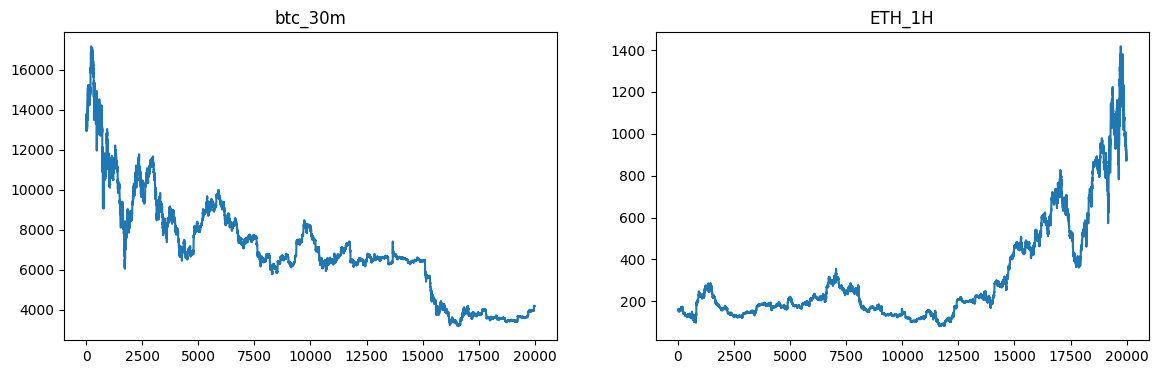

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def create_subplots(n,df=dataframes,st=stocks):
    fig, axes = plt.subplots(1, n, figsize=(7*n, 2*n))
    for i in range(n):
        data = df[i]['Open']
        axes[i].plot(data)
        axes[i].set_title(st[i][:-4])
    plt.show()
n = len(dataframes)
create_subplots(n,df=dataframes,st=stocks)

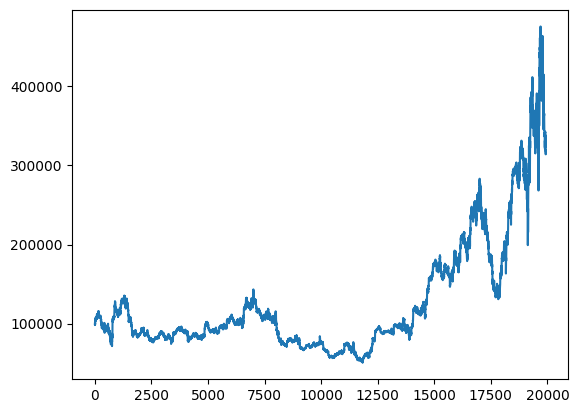

In [13]:
num_stocks=2
tmp=np.zeros(shape=(len(dataframes[0])))
cnt=0
wts=np.ones(num_stocks)/num_stocks
for i in dataframes:
    num=(100000*wts[cnt])/np.array(i['Open'][0])
    ar=np.array(i['Open'])*num
    tmp+=ar
    cnt+=1
tmp=tmp[5:-15]
tmp/=tmp[0]
tmp*=100000
plt.plot(tmp)

In [6]:

import itertools
num_stocks=len(dataframes)
boxes=2*(num_stocks-1)
rng = list(range(boxes + 1)) * num_stocks
wt_combs=[]
lol=set(i for i in itertools.permutations(rng, num_stocks) if sum(i) == boxes)
for i in lol:
    wt_combs.append(i)
wt_combs=np.array(wt_combs)
wt_combs_norm=wt_combs/boxes
print(len(wt_combs_norm))


84


In [7]:
from Env import MultiTradingEnv;
LOOKBACK=1
step=0.05
positions=np.arange(0,1,step)
positions=np.append(positions,1)
print(positions)
env = MultiTradingEnv(dataframes_array=dataframes,
                      norm_dataframes=norm_dataframes,
                       total_timesteps=len(dataframes[0])-LOOKBACK-1,
                       initial_cap=100000.0,
                       features=dataframes[0].columns,
                       lookback=LOOKBACK,
                       positions=positions,
                       wt_combs=wt_combs_norm,
                       )


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [8]:
import pandas as pd
import numpy as np
import ta
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
import math
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action','weight','next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))


    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.selu(self.layer1(x))
        x = F.selu(self.layer2(x))
        x = F.selu(self.layer3(x))
        # Reshape the output to have shape (batch_size, 3, 10)
        x = self.layer4(x).view(-1, len(env.positions),env.num_stocks)
        return x

class DQNW(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQNW, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.selu(self.layer1(x))
        x = F.selu(self.layer2(x))
        x = F.selu(self.layer3(x))
        x = self.layer4(x).view(-1, len(wt_combs_norm))
        return x


In [12]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0
EPS_DECAY = 30000
TAU = 0.005
LR = 1e-3

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(env.action_space)
n_actions = env.num_stocks*len(env.positions)
n_weights=len(wt_combs_norm)
print(n_actions)
print(n_weights)
# Get the number of state observations
state = env.reset()
n_observations = len(state.features.flatten())
print(n_observations)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
policy_net_wt = DQNW(n_observations, n_weights).to(device)
target_net_wt = DQNW(n_observations, n_weights).to(device)
i=180
# policy_net=torch.load(f'/home/siddharth/Desktop/MultiTrading/RL-Final-Env/weights/model_{i}.pth')
# policy_net_wt=torch.load(f'/home/siddharth/Desktop/MultiTrading/RL-Final-Env/weights/model_wt_{i}.pth')
target_net.load_state_dict(policy_net.state_dict())
target_net_wt.load_state_dict(policy_net_wt.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
optimizer2 = optim.AdamW(policy_net_wt.parameters(), lr=LR, amsgrad=True)




steps_done2 = 0
steps_done = 0
random_actions=0
random_actions2=0

Discrete(4)
84
84
48


In [14]:
def select_action(state):
    global steps_done
    global random_actions
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # eps_threshold=0
    if sample > eps_threshold:

        with torch.no_grad():
        # t.max(1) will return the largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
            output=policy_net(state).max(1)
            return output.indices
    else:
        random_actions+=1
        return torch.randint(0, len(env.positions), (env.num_stocks,)).unsqueeze(0)
def select_weight(state):
    global steps_done2
    global random_actions2
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done2 / EPS_DECAY)
    steps_done2 += 1
    if sample > eps_threshold:
        with torch.no_grad():
        # t.max(1) will return the largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
            output=policy_net_wt(state).max(1)
            return output.indices.unsqueeze(0)
    else:
        random_actions2+=1
        return torch.randint(0, len(wt_combs_norm),(1,)).unsqueeze(0)

In [15]:
def plot_durations(history, reward, show_result=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    durations_t = torch.tensor(history, dtype=torch.float)
    dur_t=torch.tensor(reward, dtype=torch.float).cpu()
    
    if show_result:
        fig.suptitle('Result')
    else:
        fig.suptitle('Training...')
    
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Net Worth')
    axs[0].plot(durations_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 5:
        means = durations_t.unfold(0, 5, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(4), means))
        axs[0].plot(means.numpy())
    if len(dur_t) >= 5:
        means = dur_t.unfold(0, 5, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(4), means))
        axs[1].plot(means.numpy())

    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Reward')
    # Plot reward data on the second subplot, you need to replace `reward_data` with your actual data
    axs[1].plot(dur_t.numpy())

    plt.tight_layout()
    plt.savefig('training.png')
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    # plt.show()


In [16]:
memory = ReplayMemory(1000)
def optimize_model():
    if len(memory) < BATCH_SIZE+1:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    # print(f"Batch: {batch}")
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = []
    non_final_next_states = []

    for i in range(len(batch.next_state)):
        # print(batch.next_state[i],batch.reward[i])
        # if batch.next_state[i] is not None:
            # print(batch.next_state[i])
            non_final_mask.append(batch.next_state[i].size(1) != 0)
            non_final_next_states.append(batch.next_state[i])


    non_final_mask = torch.tensor(non_final_mask, device=device, dtype=torch.bool).unsqueeze(1)
    if non_final_next_states:
        non_final_next_states = torch.cat(non_final_next_states)
    else:
        non_final_next_states = torch.tensor([], device=device)  # Empty tensor
    # print(batch.weight)
    weight_batch = torch.cat(batch.weight)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # print(state_batch.shape)
    state_action_values = policy_net(state_batch.view(BATCH_SIZE,-1)).gather(1, action_batch.unsqueeze(-1))
    # print(policy_net(state_batch.view(BATCH_SIZE,-1)).shape,action_batch.shape)
    # print(state_action_values.shape,action_batch.shape)
    # print(policy_net_wt(state_batch.view(BATCH_SIZE,-1)).unsqueeze(2).shape,weight_batch.shape)
    weight_state_action_values = policy_net_wt(state_batch.view(BATCH_SIZE,-1)).unsqueeze(2).gather(1,weight_batch.unsqueeze(-1))
    # print(weight_state_action_values.shape)
    weight_next_state_values= torch.zeros(BATCH_SIZE, device=device)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    if non_final_next_states.numel() > 0:  # Check if non_final_next_states is non-empty
        with torch.no_grad():
            # print(non_final_next_states.shape)
            next_state_values = target_net(non_final_next_states.view(BATCH_SIZE,-1)).max(1).values
            weight_next_state_values=target_net_wt(non_final_next_states.view(BATCH_SIZE,-1)).max(1).values
    # print(next_state_values, reward_batch)

    reward_batch_one = reward_batch.unsqueeze(1).repeat(1, next_state_values.size(1))
    # print(reward_batch_one)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch_one
    weight_expected_state_action_values = (weight_next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(2))
    
    loss_wt=criterion(weight_state_action_values.squeeze(1), weight_expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    optimizer2.zero_grad()
    loss.backward()
    loss_wt.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    torch.nn.utils.clip_grad_value_(policy_net_wt.parameters(), 100)
    optimizer.step()
    optimizer2.zero_grad()

In [17]:
num_episodes = 500
for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state.features, dtype=torch.float32, device=device).unsqueeze(0)
    # state = state.view(-1)
    for t in count():
        Action = select_action(state.view(-1)).to(device)
        weight = select_weight(state.view(-1)).to(device)
        observation, reward, terminated  = env.step(Action,weight)
        reward = torch.tensor([reward], device=device)
        # print(Action.shape)
        # print(weight.shape)
        # print(Action,weight)
        # if terminated:
        #     next_state = None
        # else:
        next_state = torch.tensor(observation.features, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, Action, weight, next_state, reward)
        state = next_state

        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        target_net_state_dict_wt = target_net_wt.state_dict()
        policy_net_state_dict_wt = policy_net_wt.state_dict()
        for key in policy_net_state_dict_wt:
            target_net_state_dict_wt[key] = policy_net_state_dict_wt[key]*TAU + target_net_state_dict_wt[key]*(1-TAU)
        target_net_wt.load_state_dict(target_net_state_dict_wt)
        # torch.save(policy_net,'model.pth')
        # torch.save(policy_net_wt,'model_wt.pth')
        if terminated:
            break
        env.render(episode_num=i_episode,reward=reward)
    if(i_episode%15==0):
        torch.save(policy_net, f'weights/model_{i_episode}.pth')
        torch.save(policy_net_wt, f'weights/model_wt_{i_episode}.pth')

    print(f"Random Actions:{random_actions} {random_actions2}")
    random_actions=0
    random_actions2=0
    plot_durations(history=env.history,reward=env.reward_history)
    env.render_logs()        # print(Action)
print('Complete')

[[17  7  7 11]]
[0.85 0.35 0.35 0.55]
[[ 5  0  3 18]]
[0.25 0.   0.15 0.9 ]
[[13  2  2  2]]
[0.65 0.1  0.1  0.1 ]
[[18 19 12  5]]
[0.9  0.95 0.6  0.25]
[[19 18 12 15]]
[0.95 0.9  0.6  0.75]
[[ 0 12 19  8]]
[0.   0.6  0.95 0.4 ]
[[13 13 18  8]]
[0.65 0.65 0.9  0.4 ]
[[20  6  6 18]]
[1.  0.3 0.3 0.9]
[[ 2  6  0 18]]
[0.1 0.3 0.  0.9]
[[20 15 10 19]]
[1.   0.75 0.5  0.95]
[[17 12 18  3]]
[0.85 0.6  0.9  0.15]
[[18  5 17 15]]
[0.9  0.25 0.85 0.75]
[[ 0 20 15 20]]
[0.   1.   0.75 1.  ]
[[10 12  0 13]]
[0.5  0.6  0.   0.65]
[[18  8 12  5]]
[0.9  0.4  0.6  0.25]
[[ 1 12  9  4]]
[0.05 0.6  0.45 0.2 ]
[[18 19 12  5]]
[0.9  0.95 0.6  0.25]
[[18 19 12  5]]
[0.9  0.95 0.6  0.25]
[[ 2 13 15 20]]
[0.1  0.65 0.75 1.  ]
[[ 4 19 15 18]]
[0.2  0.95 0.75 0.9 ]
[[16  8  2 13]]
[0.8  0.4  0.1  0.65]
[[20  6 14  6]]
[1.  0.3 0.7 0.3]
[[16 13  4  5]]
[0.8  0.65 0.2  0.25]
[[ 1 18  2 20]]
[0.05 0.9  0.1  1.  ]
[[19 18  4 17]]
[0.95 0.9  0.2  0.85]
[[12  0  1 16]]
[0.6  0.   0.05 0.8 ]
[[ 4  7  5 14]]
[0.2  0.

KeyboardInterrupt: 

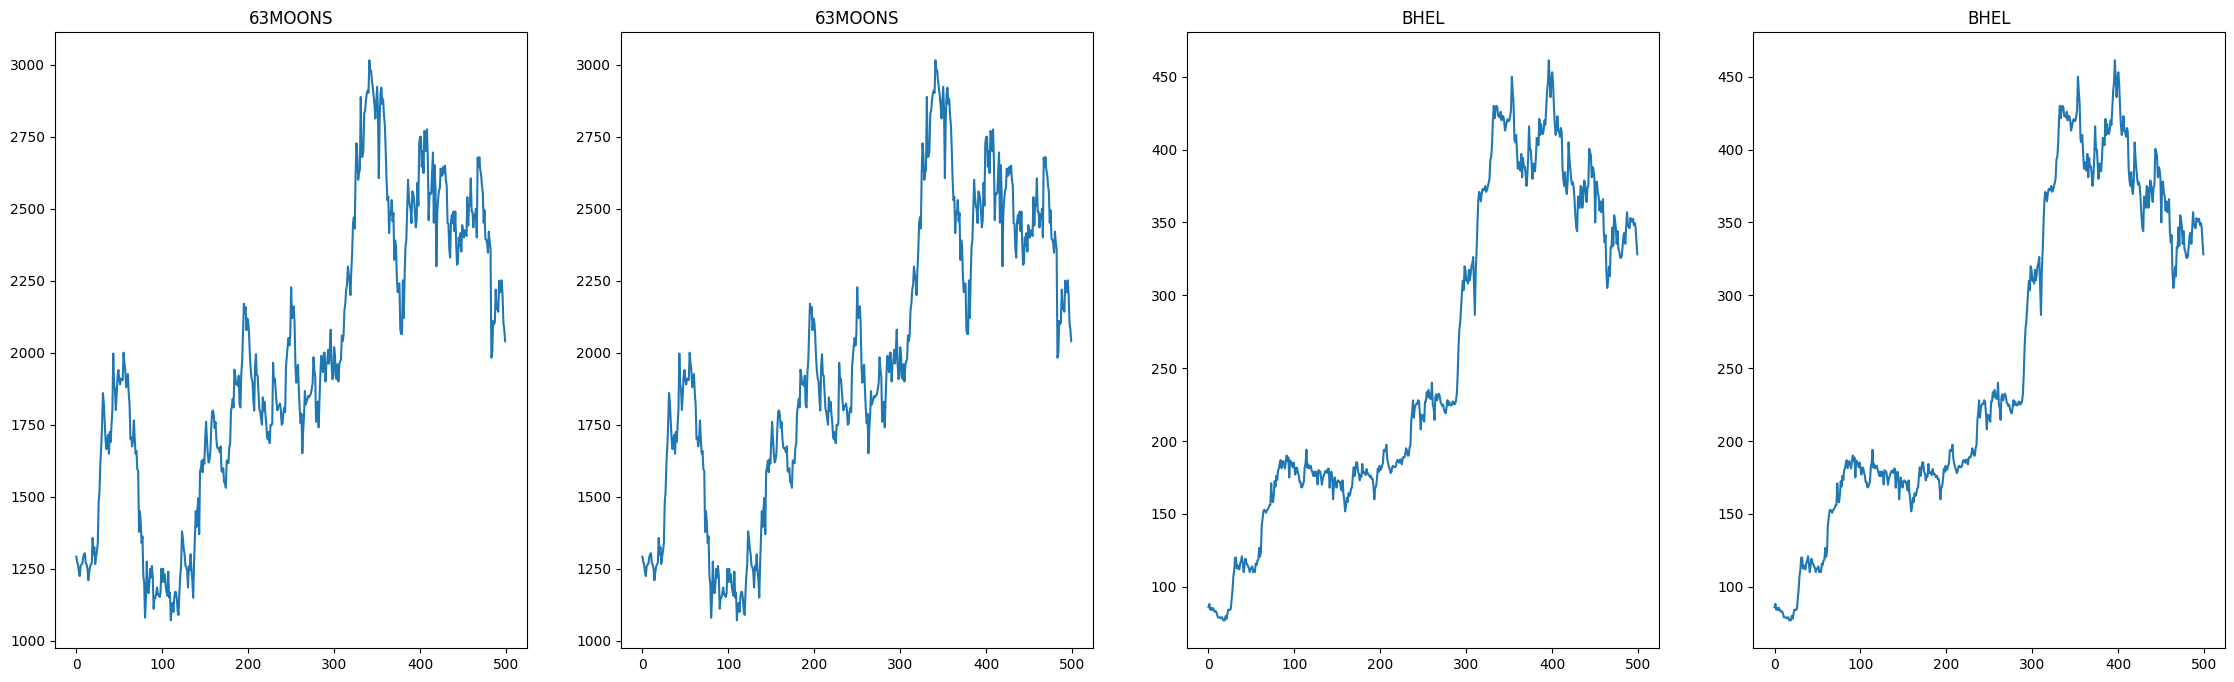

In [ ]:

test_stocks=['63MOONS.csv','63MOONS.csv','BHEL.csv','BHEL.csv']
# test_stocks=['BSOFT.csv','BIRLACORPN.csv','BLUECOAST.csv','BLUEDART.csv']
test_dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
timesteps=500
for name in test_stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    test_dataframes.append(df)
create_subplots(n=4,df=test_dataframes,st=test_stocks)

In [ ]:
norm_test_dataframes=[]
for i in range(len(test_dataframes)):
    df=test_dataframes[i]
    preprocess(df)
    test_dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_test_dataframes.append(df)

In [ ]:
from Env import MultiTradingEnv;
LOOKBACK=1
step=0.1
positions=np.arange(0,1,step)
positions=np.append(positions,1)
print(positions)
Test_Env = MultiTradingEnv(dataframes_array=test_dataframes,
                      norm_dataframes=norm_test_dataframes,
                       total_timesteps=len(test_dataframes[0])-LOOKBACK-1,
                       initial_cap=100000.0,
                       features=test_dataframes[0].columns,
                       lookback=LOOKBACK,
                       positions=positions,
                       wt_combs=wt_combs_norm,
                       )

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [ ]:
Testing_arr = []
ep_step=60
for i in range (0,500,ep_step):
    Test_Env = MultiTradingEnv(dataframes_array=test_dataframes,
                      norm_dataframes=norm_test_dataframes,
                       total_timesteps=len(test_dataframes[0])-LOOKBACK-1,
                       initial_cap=100000.0,
                       features=test_dataframes[0].columns,
                       lookback=LOOKBACK,
                       positions=positions,
                       wt_combs=wt_combs_norm,
                       )
    policy_net = DQN(n_observations, n_actions).to(device)
    policy_net_wt=DQNW(n_observations,n_actions).to(device)
    policy_net=torch.load(f'/home/siddharth/Desktop/MultiTrading/RL-Final-Env/weights/model_{i}.pth')
    policy_net_wt=torch.load(f'/home/siddharth/Desktop/MultiTrading/RL-Final-Env/weights/model_wt_{i}.pth')
    policy_net.eval()
    policy_net_wt.eval()


    state= Test_Env.reset()
    state = torch.tensor(state.features, dtype=torch.float32, device=device).unsqueeze(0)
    while(1):
        Action = policy_net(state.view(-1)).max(1).indices.to(device)
        weight = policy_net_wt(state.view(-1)).max(1).indices.to(device)
    # print(Action,weight)
        observation, reward, terminated  = Test_Env.step(Action,weight)
        reward = torch.tensor([reward], device=device)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation.features, dtype=torch.float32, device=device).unsqueeze(0)
        if terminated:
            break
        Test_Env.render(episode_num=0,reward=reward)
    Testing_arr.append(Test_Env.history_array_episode)

In [ ]:
# print(Testing_arr[6])

In [ ]:
tmp=np.zeros(shape=len(Test_Env.dataframes_array[0]))
cnt=0
wts=np.ones(num_stocks)/num_stocks
for i in Test_Env.dataframes_array:
    num=(100000*wts[cnt])/np.array(i['Open'][0])
    ar=np.array(i['Open'])*num
    tmp+=ar
    cnt+=1

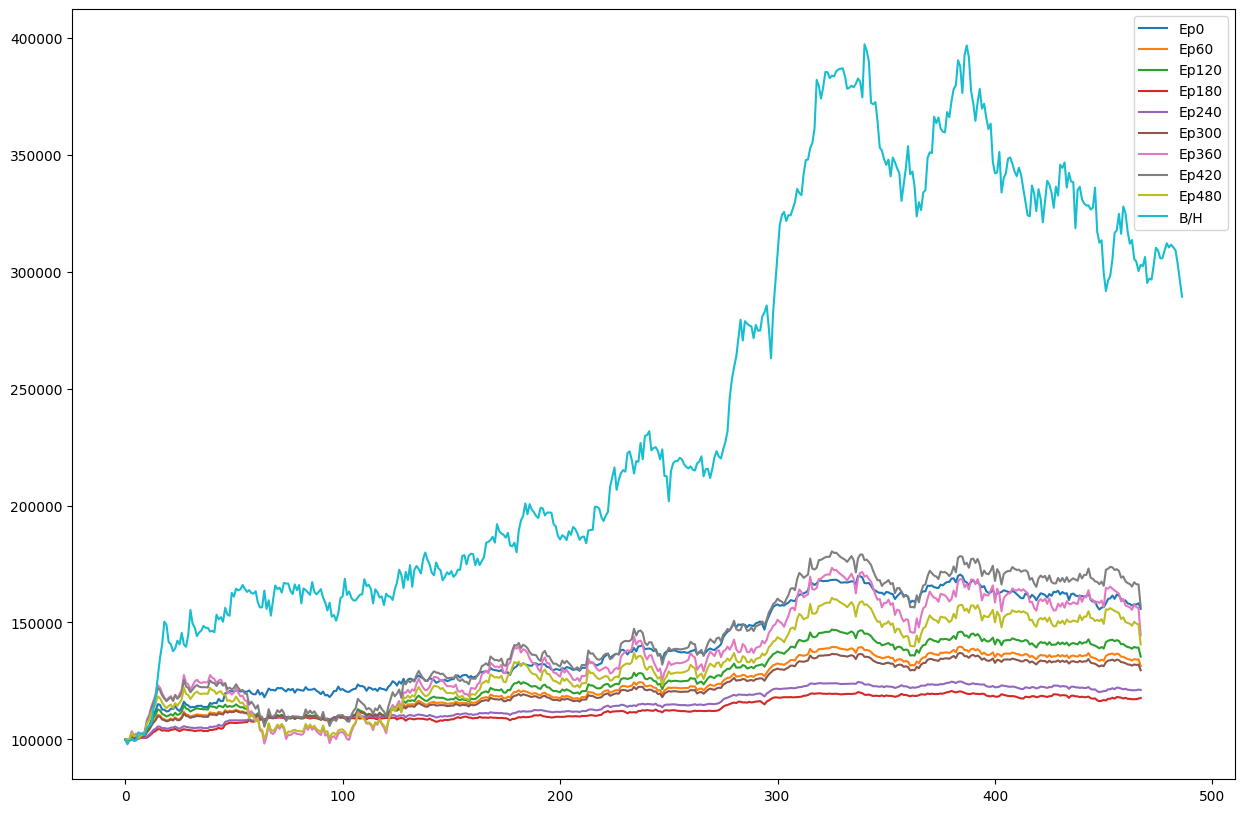

In [ ]:
plt.figure(figsize=(15, 10))
for j in range(0,len(Testing_arr)):
  plt.plot([Testing_arr[j][i][3] for i in range(len(Testing_arr[j]))],label=f'Ep{j*ep_step}')
plt.plot(tmp,label='B/H')
plt.legend()

